In [8]:
import numpy as np
import os
import sys
from os import listdir
from os.path import isfile, join, exists
import scipy.io as sio
import matplotlib.pyplot as plt
import importlib

from helpers import helpers

importlib.reload(helpers)

<module 'helpers.helpers' from '/user_data/jacobpri/Project/BOLD5000-GLMs/GLMsingle_paper/helpers/helpers.py'>

In [3]:

datasets = ['NSD','B5K']

info = dict()
info['B5K'] = dict()
info['NSD'] = dict()

info['B5K']['subjs'] = ['CSI1','CSI2','CSI3','CSI4']
info['NSD']['subjs'] = ['subj01','subj02','subj03','subj04']

info['methods'] = ['assumehrf', 'fithrf', 'fithrf_glmdenoise', 'fithrf_glmdenoise_rr',
                   'assumehrf_lss', 'assumehrf_rr', 'fithrf_lss', 'fithrf_rr']

exclude_within_session_repeats = False

masks = np.load('masks.npy',allow_pickle=True).item()


In [10]:
reliability = dict()

# check to be sure all the datafiles exist
for ds in datasets:
    
    reliability[ds] = dict()
    
    for subj in info[ds]['subjs']:
        
        subj_version_list = []
        
        reliability[ds][subj] = dict()

        for method in info['methods']:
        
            if exclude_within_session_repeats is True:
                metric_savefn = f'reliability_data/{ds}_{subj}_{method}_reliability_strict.npy'
            else:
                metric_savefn = f'reliability_data/{ds}_{subj}_{method}_reliability.npy'
        
            rel = np.load(metric_savefn)
            
            mask = masks[ds][subj]==1
            
            if np.ndim(rel) == 3:
                rel = rel[mask==1]
                
            print(ds,method,subj,rel.shape)
            
            reliability[ds][subj][method] = rel
            
            subj_version_list.append(rel)
                        
        reliability[ds][subj]['mean'] = np.mean(np.stack(subj_version_list,axis=1),axis=1)



NSD assumehrf subj01 (29723,)
NSD fithrf subj01 (29723,)
NSD fithrf_glmdenoise subj01 (29723,)
NSD fithrf_glmdenoise_rr subj01 (29723,)
NSD assumehrf_lss subj01 (29723,)
NSD assumehrf_rr subj01 (29723,)
NSD fithrf_lss subj01 (29723,)
NSD fithrf_rr subj01 (29723,)
NSD assumehrf subj02 (25655,)
NSD fithrf subj02 (25655,)
NSD fithrf_glmdenoise subj02 (25655,)
NSD fithrf_glmdenoise_rr subj02 (25655,)
NSD assumehrf_lss subj02 (25655,)
NSD assumehrf_rr subj02 (25655,)
NSD fithrf_lss subj02 (25655,)
NSD fithrf_rr subj02 (25655,)
NSD assumehrf subj03 (28033,)
NSD fithrf subj03 (28033,)
NSD fithrf_glmdenoise subj03 (28033,)
NSD fithrf_glmdenoise_rr subj03 (28033,)
NSD assumehrf_lss subj03 (28033,)
NSD assumehrf_rr subj03 (28033,)
NSD fithrf_lss subj03 (28033,)
NSD fithrf_rr subj03 (28033,)
NSD assumehrf subj04 (23155,)
NSD fithrf subj04 (23155,)
NSD fithrf_glmdenoise subj04 (23155,)
NSD fithrf_glmdenoise_rr subj04 (23155,)
NSD assumehrf_lss subj04 (23155,)
NSD assumehrf_rr subj04 (23155,)
NSD f

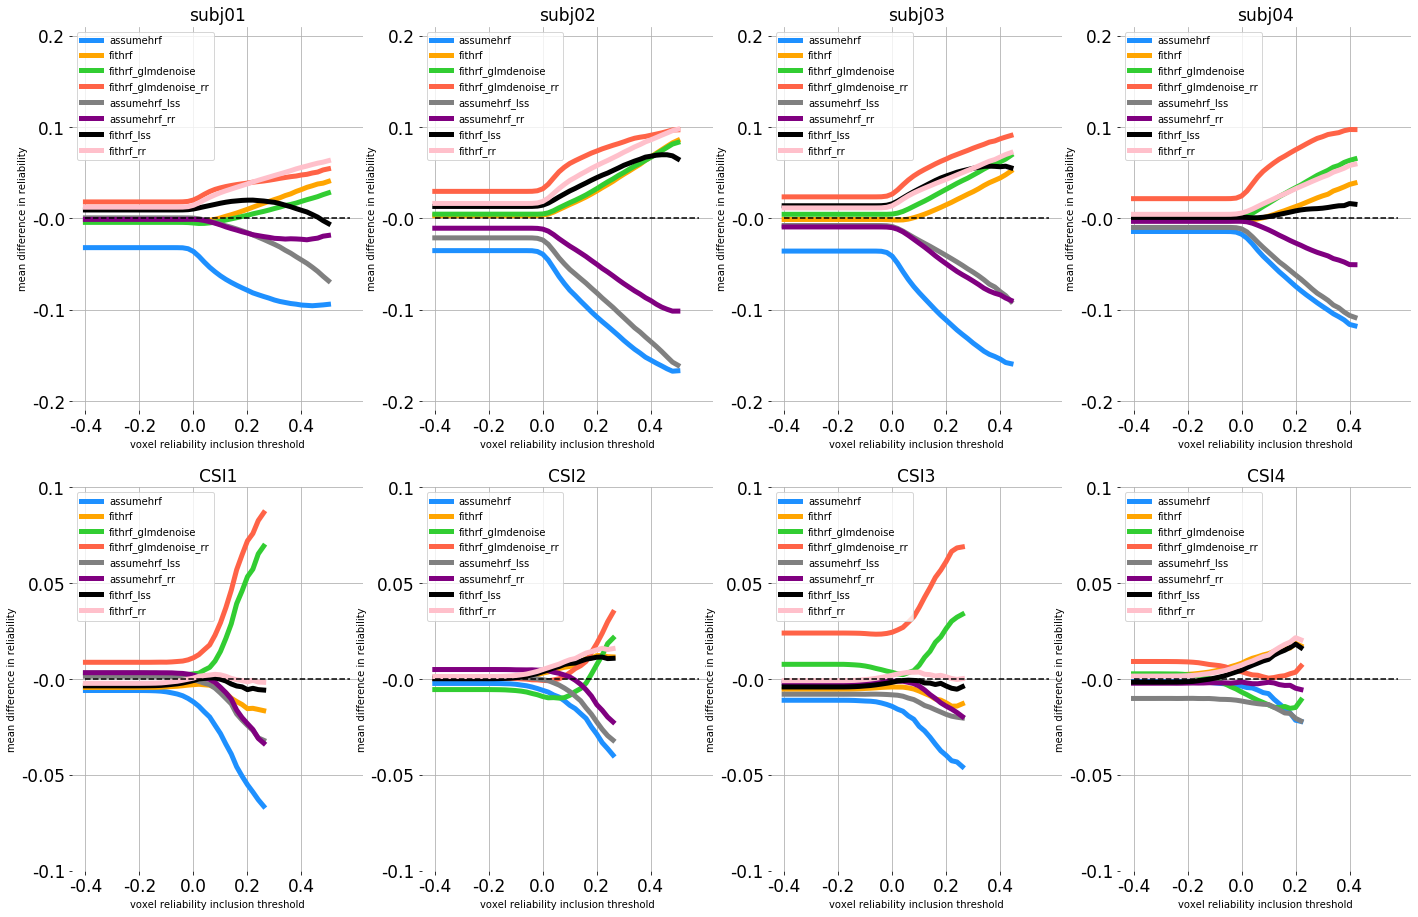

In [11]:
ft = 16
colors = ['dodgerblue','orange','limegreen','tomato','gray','purple','black','pink','black']

bins  = np.round(np.arange(-0.4,0.6,0.02),3)

measure = 'mean'
min_nvox = 250

allsubj_diffs = dict()

for method in info['methods']:
    allsubj_diffs[method] = []

plt.figure(figsize=(24,24))
c = 1

# iterate through datasets
for ds in ['NSD','B5K']:
        
    if ds == 'NSD':
        subjs = [f'subj0{n}' for n in range(1,5)]
    else:
        subjs = [f'CSI{n}' for n in range(1,5)]
            
    # iterate through subjects
    for subj in subjs:
        
        plt.subplot(len(ds),4,c)
        
        subj_mean_metric = reliability[ds][subj]['mean']
        
        subj_version_diffs = []
        
        # iterate through versions
        v=0
        for method in info['methods']:
    
            this_version = reliability[ds][subj][method]
            this_version_diffs = []
            this_version_stds = []
            for val in bins:
                
                validvox = subj_mean_metric > val

                if np.sum(validvox) > min_nvox:
                    if measure == 'mean':
                        this_version_diffs.append(np.nanmean(this_version[validvox] - subj_mean_metric[validvox]))
                    elif measure == 'median':
                        this_version_diffs.append(np.nanmedian(this_version[validvox] - subj_mean_metric[validvox]))
                    this_version_stds.append(np.nanstd(this_version[validvox] - subj_mean_metric[validvox]))
                else:
                    this_version_diffs.append(np.nan)
                    this_version_stds.append(np.nan)
                    
            
            subj_version_diffs.append(this_version_diffs)
            plt.plot(this_version_diffs,linewidth=5,color = colors[v])
           
            v+=1
            
            allsubj_diffs[method].append(this_version_diffs)
        
        c+=1
        plt.plot(np.zeros((len(bins),)),'k--')
        plt.xticks(np.arange(len(bins))[::10],np.array(bins[::10]),fontsize=ft);
        
        if ds == 'NSD':
            plt.yticks(np.round(np.arange(-0.4,0.3,0.1),2),np.round(np.arange(-0.4,0.3,0.1),2),fontsize=ft)
            plt.ylim([-0.21,0.21])
        else:
            plt.yticks(np.round(np.arange(-0.4,0.3,0.05),2),np.round(np.arange(-0.4,0.3,0.05),2),fontsize=ft)
            plt.ylim([-0.1,0.1])
       
        plt.xticks(fontsize=ft+1)
        plt.yticks(fontsize=ft+1)
        plt.title(subj,fontsize=ft+1)
        plt.xlabel('voxel reliability inclusion threshold')
        plt.ylabel('mean difference in reliability')
        plt.grid('on')         
        plt.legend(info['methods'],loc='upper left')
        # get rid of the frame
        for spine in plt.gca().spines.values():
            spine.set_visible(False)
                        


/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


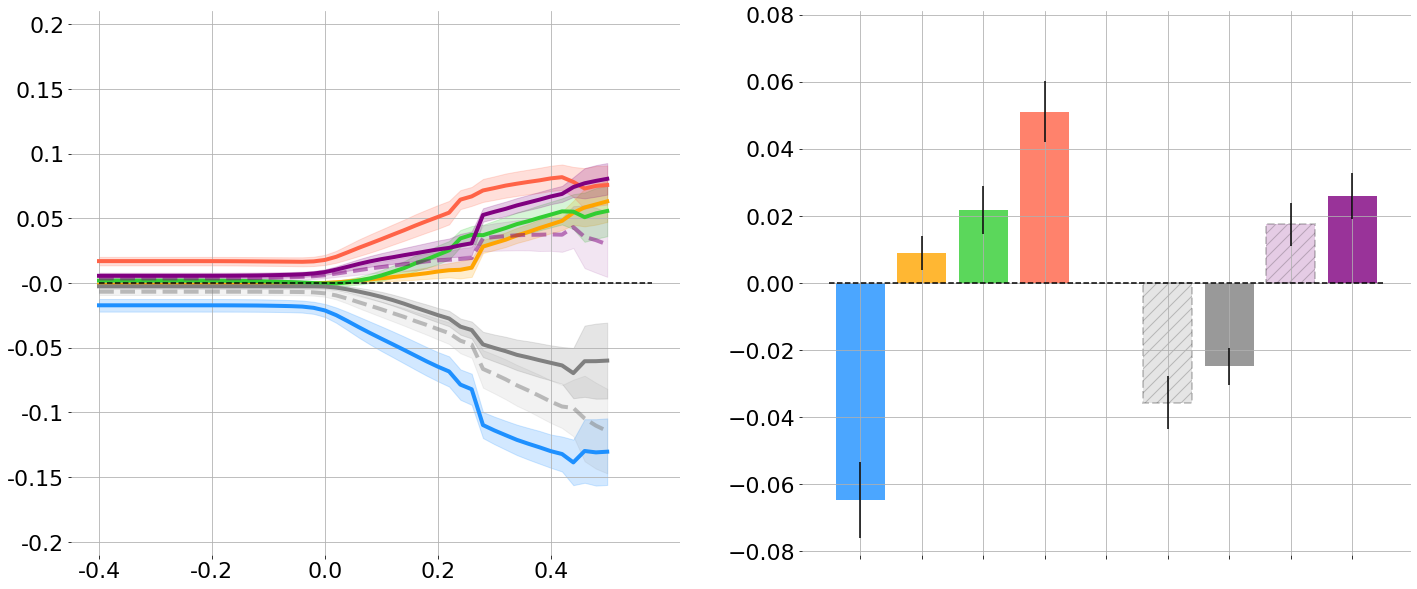

In [6]:
ft = 16
colors = ['dodgerblue','orange','limegreen','tomato','gray','gray','purple','purple','black']
colors_ = ['dodgerblue','orange','limegreen','tomato','black','gray','gray','purple','purple','black']

bins  = np.round(np.arange(-0.4,0.6,0.02),3)

bar_thresh = 0.2
bar_idx = np.squeeze(np.argwhere(bins == bar_thresh))

plt.figure(figsize=(24,10))
c = 0

nsubjs = dict()
for method in info['methods']:
    nsubjs[method] = []
    
    for i in range(len(bins)):
        nsubjs[method].append(np.sum(~np.isnan(np.stack(allsubj_diffs[method],axis=1)[i])))
        
bar_vals = []
bar_sems = []

for method in info['methods']:
    method_mean = np.nanmean(np.stack(allsubj_diffs[method],axis=1),axis=1)
    method_std = np.nanstd(np.stack(allsubj_diffs[method],axis=1),axis=1) / np.sqrt(np.array(nsubjs[method]))
    if method == 'assumehrf_lss':
        lst = '--'
    elif method == 'fithrf_lss':
        lst = '--'
    else:
        lst = '-'
    
    plt.subplot(121)
    if 'lss' in method:
        a = 0.1
    else:
        a = 0.2
    plt.fill_between(np.arange(len(bins)),np.array(method_mean)-np.array(method_std),
                     np.array(method_mean)+np.array(method_std),alpha=a,color=colors[c])
    
    if 'lss' in method:
        lalpha = 0.5
    else:
        lalpha = 1
    plt.plot(method_mean,linewidth=4,color = colors[c],linestyle = lst,alpha=lalpha)
    
    bar_vals.append(method_mean[bar_idx])
    bar_sems.append(method_std[bar_idx])
    
    if 'denoise_rr' in method:
        bar_vals.append(np.nan)
        bar_sems.append(np.nan)


    c+=1
    
plt.plot(np.zeros((len(bins),)),'k--')
plt.xticks(np.arange(len(bins))[::10],np.array(bins[::10]),fontsize=ft);

plt.yticks(np.round(np.arange(-0.4,0.3,0.05),2),np.round(np.arange(-0.4,0.3,0.05),2),fontsize=ft)
plt.ylim([-0.21,0.21])


plt.xticks(fontsize=ft+6)
plt.yticks(fontsize=ft+6)

plt.grid('on')         

# get rid of the frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
plt.subplot(122)
bars = plt.bar(np.arange(len(bar_vals)),np.array(bar_vals),yerr=np.array(bar_sems),
               color=colors_[:-1],alpha=0.8,linewidth=2)#facecolor=(1,1,1,1,0,1,0,1))
for lssbar in [5,7]:
    bars[lssbar].set_alpha(0.2)
    bars[lssbar].set_edgecolor('black')
    bars[lssbar].set_linestyle('--')
    bars[lssbar].set_hatch('//')
    
plt.plot(np.arange(len(bar_vals)+1)-0.5,np.zeros((len(bar_vals)+1,)),'k--')
plt.yticks(fontsize=ft+6)
plt.ylim([-0.081,0.081])
plt.xticks(np.arange(len(bar_vals)),np.array(['' for i in range(len(bar_vals))]))
plt.grid('on')         
# get rid of the frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)



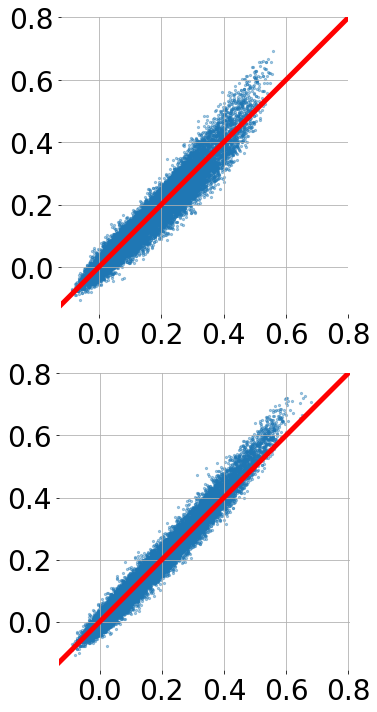

In [7]:
ds = 'NSD'
subj = 'subj01'
colors_ = ['gray','purple']

c = 1

plt.figure(figsize=(8,12))

for i in range(2):
    
    plt.subplot(2,1,c)
    
    fields = [['assumehrf_lss','assumehrf_rr'], ['fithrf_lss', 'fithrf_rr']]
    a = reliability[ds][subj][fields[i][0]]
    b = reliability[ds][subj][fields[i][1]]
    plt.grid('on')
    plt.scatter(a, b, 5, alpha = 0.4)
    plt.axis('square')

    plt.plot(np.arange(-0.6,0.9,0.01),np.arange(-0.6,0.9,0.01),'r',linewidth=5,zorder=10)

    if ds == 'NSD':
        ticks = (0,1,0.2)
    else:
        ticks = (-0.3,0.8,0.4)

    plt.xticks(np.round(np.arange(ticks[0],ticks[1],ticks[2]),2),
               np.round(np.arange(ticks[0],ticks[1],ticks[2]),2),fontsize=28)
    plt.yticks(np.round(np.arange(ticks[0],ticks[1],ticks[2]),2),
               np.round(np.arange(ticks[0],ticks[1],ticks[2]),2),fontsize=28)
    
    # get rid of the frame
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
        
    c+=1